In [1]:
%pip install scipy
# Force reload of imported modules
%load_ext autoreload
%autoreload 2

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist
import math
from scipy import ndimage
from skimage import measure
import numpy as np

In [87]:
from iq_helper import *
from augmentations import *

def get_file_path(iq_number):
    # Convert number (1-10) to file path "iq_images/iq{i}.png" but with a leading zero if i < 10
    return f"iq_images/iq{str(iq_number).zfill(2)}.png"

def get_image(file_path):
    original_image = cv2.imread(file_path)
    return original_image

def get_grayscale_image(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def get_contours(image, isGray = False, isBinary = False, invert = False):
    gray = get_grayscale_image(image) if not isGray else image
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV) if not isBinary else (0, image)
    if invert:
        binary = cv2.bitwise_not(binary)
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # it is possible a contour is found around the border of the image, so remove it
    threshold = 0.95
    contours = [contour for contour in contours if cv2.contourArea(contour) / (image.shape[0] * image.shape[1]) < threshold]
    return contours

def align_images(image1, image2, same_shape = False):
    a_contours = get_contours(image1, True, invert=True)
    b_contours = get_contours(image2, True, invert=True)
    # show_image(draw_contours(image1, a_contours))
    a_contours = sorted(a_contours, key=cv2.contourArea, reverse=True)
    b_contours = sorted(b_contours, key=cv2.contourArea, reverse=True)
    x, y, w, h = cv2.boundingRect(a_contours[0])
    image1 = image1[y:y+h, x:x+w]
    x, y, w, h = cv2.boundingRect(b_contours[0])
    image2 = image2[y:y+h, x:x+w]
    if same_shape:
        # Grow the smaller image to the size of the larger image
        if image1.shape[0] > image2.shape[0]:
            image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
        else:
            image1 = cv2.resize(image1, (image2.shape[1], image2.shape[0]))
    return image1, image2

def remove_background(image1, image2):
    base = cv2.bitwise_and(image1, image2)
    image1 = cv2.bitwise_xor(image1, base)
    image2 = cv2.bitwise_xor(image2, base)
    # clean up the images
    image1 = cv2.medianBlur(image1, 5)
    image2 = cv2.medianBlur(image2, 5)
    return image1, image2

def process_images(image1, image2, align = True, remove_bg = True):
    # Align the images
    if align:
        image1, image2 = align_images(image1, image2, True)
    # Remove the background
    if remove_bg:
        image1, image2 = remove_background(image1, image2)
    else:
        # apply a median blur to the images to remove noise
        image1 = cv2.medianBlur(image1, 5)
        image2 = cv2.medianBlur(image2, 5)
    # convert them to binary images
    image1 = force_to_binary(image1)
    image2 = force_to_binary(image2)
    
    return image1, image2

# imgs, _ = get_iq_question_images(17)
# show_images_grid(imgs)
# img1, img2 = imgs[0], imgs[1]
# img1, img2 = process_images(img1, img2, align=True, remove_bg=True)
# show_images_grid([img1, img2])

Original and destination images (no background), then with background:


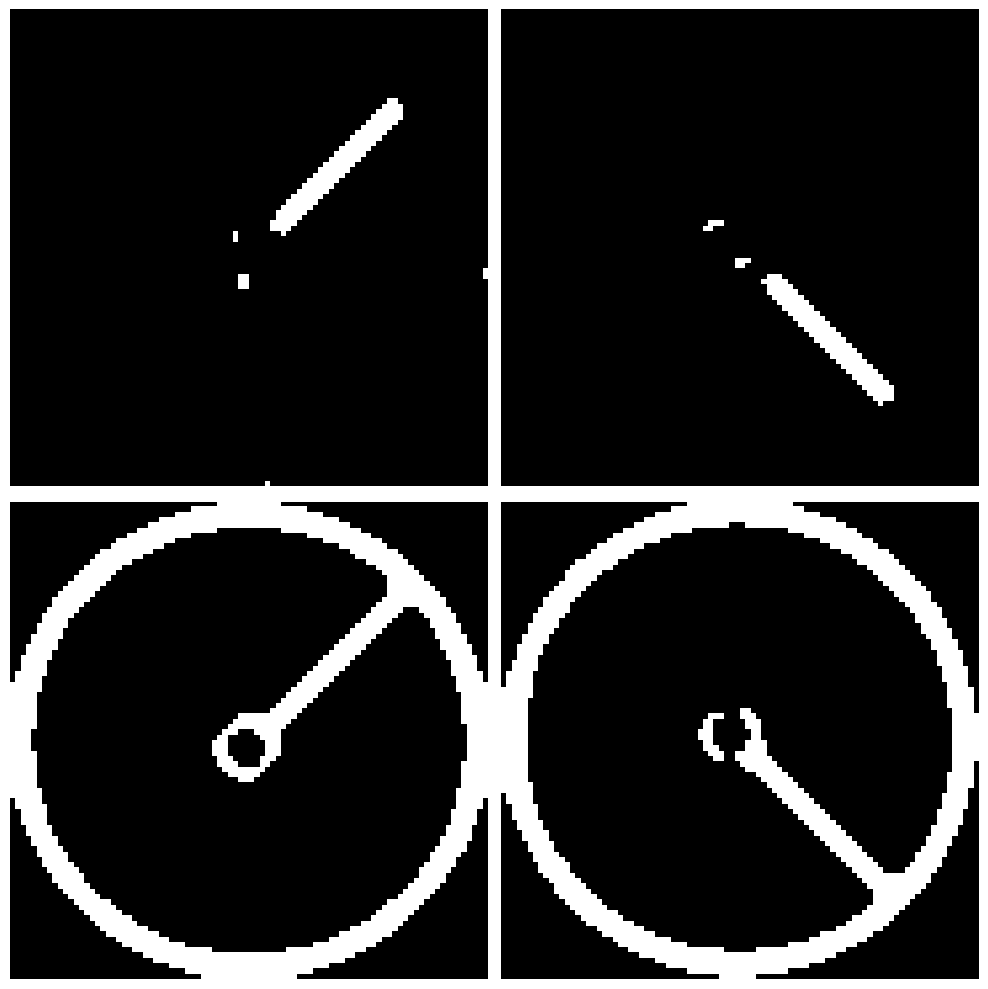

Best angle: 90, score: 0.009134167279862644
Best angle of 90 with image, next to tried angle of 90


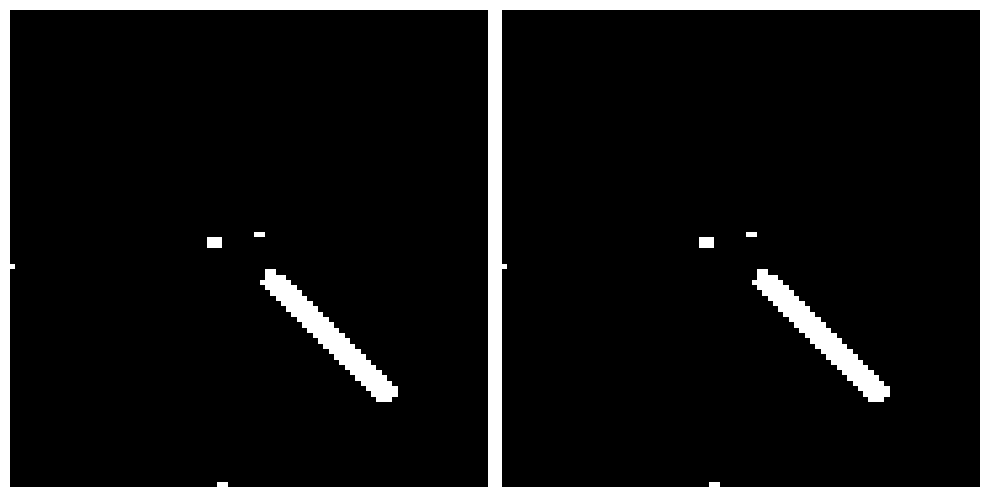

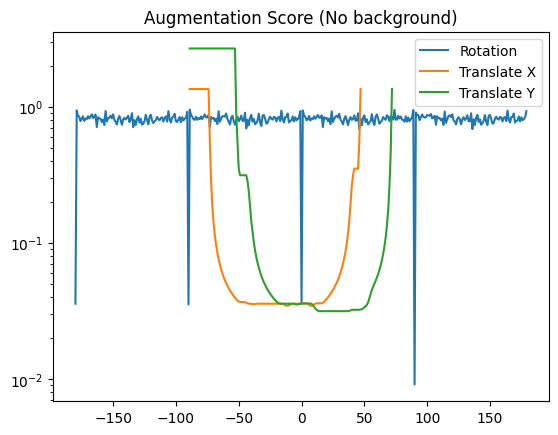

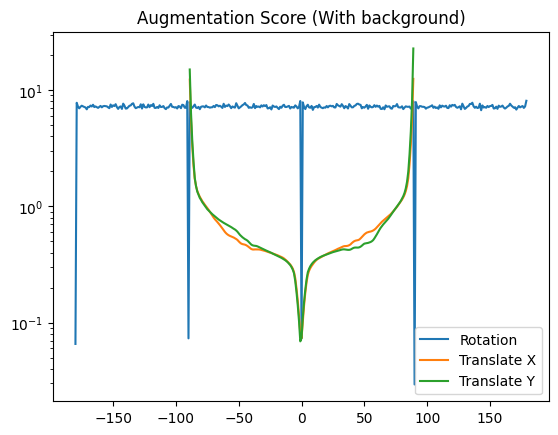

Original and destination images (no background), then with background:


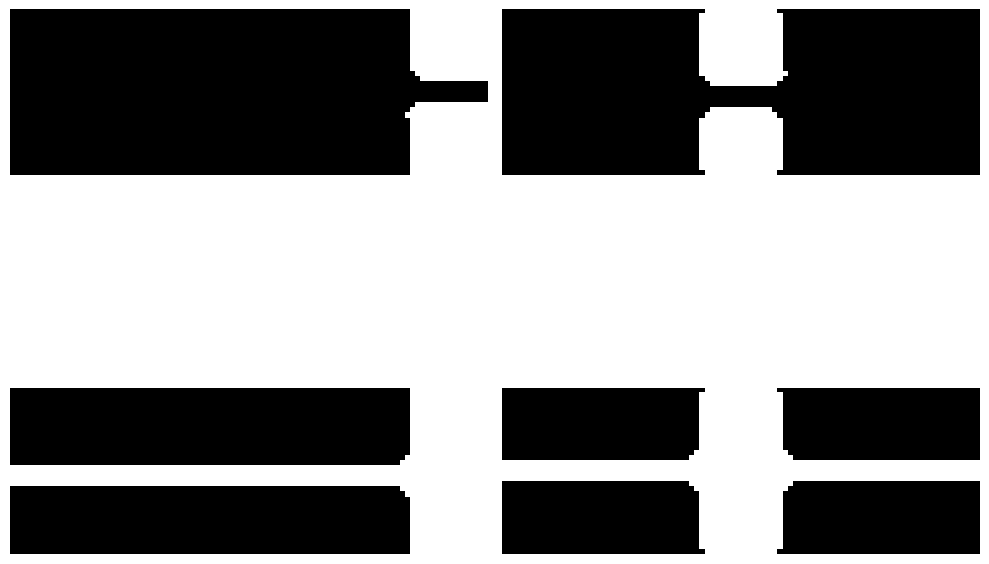

Best offset of (-39, 0) with image, next to tried offset_x of -40


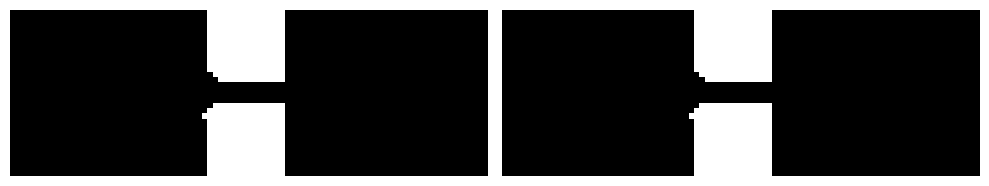

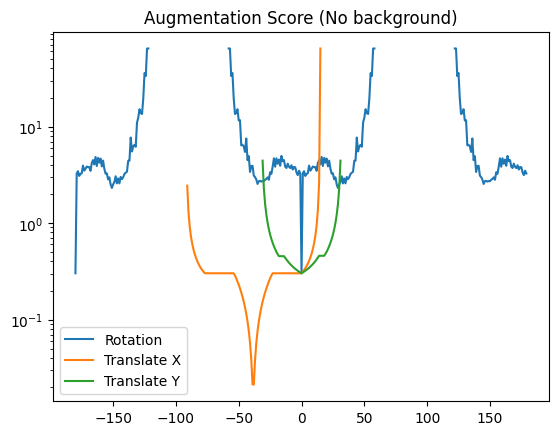

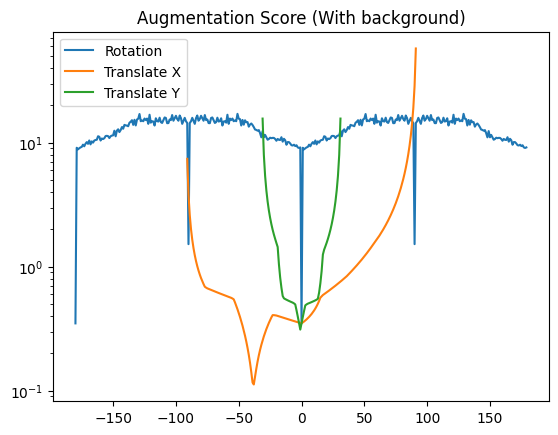

In [99]:
# New approach: Use Gradient Descent or similar to learn the parameters of the augmentation.
# We have base augmentations: Rotate, Flipping, Stretching, Cropping, Color change, and Translation. (Potential: bitwise logic like XOR)

def get_angle(org, dest):
    # Try to find the angle that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try angles from -180 to 180 in steps of 1 degree
    angles = range(-180, 180)
    best_angle = None
    best_score = float('inf')
    for angle in angles:
        score = augmentation_score(RotateAugmentation(angle), org, dest)
        if score < best_score:
            best_score = score
            best_angle = angle
    print(f"Best angle: {best_angle}, score: {best_score}")
    return best_angle, best_score

def get_offset(org, dest):
    # Try to find the offset that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try offsets from -width to width and -height to height in steps of 1 pixel
    height, width = org.shape[:2]
    best_offset = None
    best_score = float('inf')
    for dx in range(-width, width):
        for dy in range(-height, height):
            translated = TranslateAugmentation(dx, dy)(org)
            score = np.sum(np.abs(translated - dest))
            if score < best_score:
                best_score = score
                best_offset = (dx, dy)
    print(f"Best offset: {best_offset}, score: {best_score}")
    return best_offset, best_score

def get_offset_x(org, dest):
    # Try to find the offset that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try offsets from -width to width and -height to height in steps of 1 pixel
    height, width = org.shape[:2]
    best_offset = None
    best_score = float('inf')
    for dx in range(-width, width):
        # translated = TranslateAugmentation(dx, 0)(org)
        # score = np.sum(np.abs(translated - dest))
        score = augmentation_score(TranslateAugmentation(dx, 0), org, dest)
        if score < best_score:
            best_score = score
            best_offset = (dx, 0)
    return best_offset, best_score
def get_mirror_angle(org, dest):
    # Try to find the angle that minimizes the difference between the two images
    # We will use the sum of absolute differences as a measure of similarity
    # We will try angles from -180 to 180 in steps of 1 degree
    angles = range(0, 180)
    best_angle = None
    best_score = float('inf')
    for angle in angles:
        flipped = FlipAugmentation(angle)(org)
        score = np.sum(np.abs(flipped - dest))
        if score < best_score:
            best_score = score
            best_angle = angle
    print(f"Best angle: {best_angle}, score: {best_score}")
    return best_angle, best_score

def test_rotation():
    images, _ = get_iq_question_images(17)
    org, dest = images[1], images[2]
    org_with_bg, dest_with_bg = org.copy(), dest.copy()
    org_with_bg, dest_with_bg = process_images(org_with_bg, dest_with_bg, remove_bg=False, align=True)
    org, dest = process_images(org, dest, remove_bg=True, align=True)
    print(f"Original and destination images (no background), then with background:")
    show_images_grid([org, dest, org_with_bg, dest_with_bg])
    # Need them to have the same size
    angle, score = get_angle(org, dest)
    angle_test = 90
    print(f"Best angle of {angle} with image, next to tried angle of {angle_test}")
    aug_img = RotateAugmentation(angle)(org)
    aug_test_img = RotateAugmentation(angle_test)(org)
    show_images_grid([aug_img, aug_test_img])

    # Try plotting the score for different angles, scores for offset x, and scores for offset y
    angles = range(-180, 180)
    rotation_scores = [augmentation_score(RotateAugmentation(angle), org, dest) for angle in angles]
    plt.plot(angles, rotation_scores)
    offset_x = range(-org.shape[1], org.shape[1])
    offset_x_scores = [augmentation_score(TranslateAugmentation(dx, 0), org, dest) for dx in offset_x]
    plt.plot(offset_x, offset_x_scores)
    offset_y = range(-org.shape[0], org.shape[0])
    offset_y_scores = [augmentation_score(TranslateAugmentation(0, dy), org, dest) for dy in offset_y]
    plt.plot(offset_y, offset_y_scores)

    plt.title("Augmentation Score (No background)")
    plt.yscale('log')
    plt.legend(["Rotation", "Translate X", "Translate Y"])
    plt.show()

    angles = range(-180, 180)
    rotation_scores = [augmentation_score(RotateAugmentation(angle), org_with_bg, dest_with_bg) for angle in angles]
    plt.plot(angles, rotation_scores)
    offset_x = range(-org_with_bg.shape[1], org_with_bg.shape[1])
    offset_x_scores = [augmentation_score(TranslateAugmentation(dx, 0), org_with_bg, dest_with_bg) for dx in offset_x]
    plt.plot(offset_x, offset_x_scores)
    offset_y = range(-org_with_bg.shape[0], org_with_bg.shape[0])
    offset_y_scores = [augmentation_score(TranslateAugmentation(0, dy), org_with_bg, dest_with_bg) for dy in offset_y]
    plt.plot(offset_y, offset_y_scores)

    plt.title("Augmentation Score (With background)")
    plt.yscale('log')
    plt.legend(["Rotation", "Translate X", "Translate Y"])
    plt.show()


def test_translation():
    # Testing translation
    images, _ = get_iq_question_images(4)
    org, dest = images[0], images[1]
    org_with_bg, dest_with_bg = org.copy(), dest.copy()
    org_with_bg, dest_with_bg = process_images(org_with_bg, dest_with_bg, remove_bg=False, align=True)
    org, dest = process_images(org, dest, remove_bg=True, align=True)
    print(f"Original and destination images (no background), then with background:")
    show_images_grid([org, dest, org_with_bg, dest_with_bg])
    # Need them to have the same size
    final_offset, score = get_offset_x(org, dest)
    offset_test = -40
    print(f"Best offset of {final_offset} with image, next to tried offset_x of {offset_test}")
    aug_img = TranslateAugmentation(final_offset[0], final_offset[1])(org)
    aug_test_img = TranslateAugmentation(offset_test, 0)(org)
    show_images_grid([aug_img, aug_test_img])
    
    # Try plotting the score for different angles, scores for offset x, and scores for offset y
    angles = range(-180, 180)
    rotation_scores = [augmentation_score(RotateAugmentation(angle), org, dest) for angle in angles]
    plt.plot(angles, rotation_scores)
    offset_x = range(-org.shape[1], org.shape[1])
    offset_x_scores = [augmentation_score(TranslateAugmentation(dx, 0), org, dest) for dx in offset_x]
    plt.plot(offset_x, offset_x_scores)
    offset_y = range(-org.shape[0], org.shape[0])
    offset_y_scores = [augmentation_score(TranslateAugmentation(0, dy), org, dest) for dy in offset_y]
    plt.plot(offset_y, offset_y_scores)

    plt.title("Augmentation Score (No background)")
    plt.yscale('log')
    plt.legend(["Rotation", "Translate X", "Translate Y"])
    plt.show()

    angles = range(-180, 180)
    rotation_scores = [augmentation_score(RotateAugmentation(angle), org_with_bg, dest_with_bg) for angle in angles]
    plt.plot(angles, rotation_scores)
    offset_x = range(-org_with_bg.shape[1], org_with_bg.shape[1])
    offset_x_scores = [augmentation_score(TranslateAugmentation(dx, 0), org_with_bg, dest_with_bg) for dx in offset_x]
    plt.plot(offset_x, offset_x_scores)
    offset_y = range(-org_with_bg.shape[0], org_with_bg.shape[0])
    offset_y_scores = [augmentation_score(TranslateAugmentation(0, dy), org_with_bg, dest_with_bg) for dy in offset_y]
    plt.plot(offset_y, offset_y_scores)

    plt.title("Augmentation Score (With background)")
    plt.yscale('log')
    plt.legend(["Rotation", "Translate X", "Translate Y"])
    plt.show()

    

def plot_different_augmentations():
    data = iq_test_to_squares(get_image('iq_images/iq17.png'))
    org = data[1]
    dest = data[2]
    
    org, dest = process_images(org, dest, remove_bg=True)
    show_image(org)
    show_image(dest)
    angles = range(-180, 180)
    scores = [augmentation_score(RotateAugmentation(angle), org, dest) for angle in angles]
    plt.title("Rotation score")
    plt.plot(angles, scores)
    plt.xlabel("Angle (degrees)")
    plt.show()
    offset_x = range(-org.shape[1], org.shape[1])
    scores = [augmentation_score(TranslateAugmentation(dx, 0), org, dest) for dx in offset_x]
    plt.title("Translation X score")
    plt.plot(offset_x, scores)
    plt.xlabel("Offset (pixels)")
    plt.show()
    offset_y = range(-org.shape[0], org.shape[0])
    scores = [augmentation_score(TranslateAugmentation(0, dy), org, dest) for dy in offset_y]
    plt.title("Translation Y score")
    plt.plot(offset_y, scores)
    plt.xlabel("Offset (pixels)")
    plt.show()

    # try translate x by 60
    aug_img = TranslateAugmentation(60, 0)(org)
    show_image(aug_img)
    # try translate y by 72
    aug_img = TranslateAugmentation(0, 72)(org)
    show_image(aug_img)
    # try translate y by -90
    aug_img = TranslateAugmentation(0, -90)(org)
    show_image(aug_img)
    
test_rotation()
test_translation()
# plot_different_augmentations()

In [21]:
# Gradient descent (or sort of like binary search?) to find the optimal angle, offset, or other parameters

def gradient_descent(create_augmentation, parameter_range, org, dest, debug=False):
    tried_x = []
    tried_y = []
    def score(parameter):
        score = augmentation_score(create_augmentation(parameter), org, dest)
        tried_x.append(parameter)
        tried_y.append(score)
        return score
    start, stop = parameter_range
    golden_ratio = (1 + 5 ** 0.5) / 2
    max_iterations = 100
    tolerance = 3
    for _ in range(max_iterations):
        if debug:
            print(f"Range: {start} - {stop}")
        range_size = stop - start
        if range_size < tolerance:
            break

        mid1 = stop - range_size / golden_ratio
        mid2 = start + range_size / golden_ratio
        # these must be integers
        mid1 = round(mid1)
        mid2 = round(mid2)

        score1 = score(mid1)
        score2 = score(mid2)

        if score1 < score2:
            stop = mid2
        else:
            start = mid1

    optimal_parameter = (start + stop) / 2
    return optimal_parameter, (tried_x, tried_y)

def gradient_descent_2(create_augmentation, parameter_range, org, dest, debug=False):
    tried_x = []
    tried_y = []
    def score(parameter):
        score = augmentation_score(create_augmentation(parameter), org, dest)
        tried_x.append(parameter)
        tried_y.append(score)
        return score
    def avg_score(parameter):
        return np.mean([score(parameter + dx) for dx in [-1, 0, 1]])
    # The idea of this is two try nearby parameters to determine the direction to go
    start, stop = parameter_range
    def converge(init):
        current = init
        max_iterations = 20
        for _ in range(max_iterations):
            current_score = avg_score(current)
            nearby = [current - 10, current + 10]
            nearby_scores = [avg_score(n) for n in nearby]
            if current_score < nearby_scores[0] and current_score < nearby_scores[1]:
                return current, current_score
            if nearby_scores[0] < nearby_scores[1]:
                current = nearby[0]
            else:
                current = nearby[1]
        return current, current_score
    # Try different random initializations
    best_score = float('inf')
    best_parameter = None
    for _ in range(5):
        init = np.random.uniform(start, stop)
        init = round(init)
        parameter, this_score = converge(init)
        if this_score < best_score:
            best_score = this_score
            best_parameter = parameter
    return best_parameter, (tried_x, tried_y)   

# Use gradient_descent to find the best score and parameters for each type of augmentation, and choose the best
def learn_parameters(org, dest):
    # The augmentation could be any of the base augmentations
    augmentations = [RotateAugmentation, lambda dx: TranslateAugmentation(dx, 0), lambda dy: TranslateAugmentation(0, dy)]
    names = ["Rotate", "Translate X", "Translate Y"]
    parameters = [(-180, 180), (-org.shape[1], org.shape[1]), (-org.shape[0], org.shape[0])]
    best_score = float('inf')
    best_result = None
    for name, create_augmentation, parameter_range in zip(names, augmentations, parameters):
        optimal_parameter, _ = gradient_descent(create_augmentation, parameter_range, org, dest)
        optimal_parameter = round(optimal_parameter)
        score = augmentation_score(create_augmentation(optimal_parameter), org, dest)
        print(f"Optimal parameter for {name}: {optimal_parameter}, score: {score}")
        if score < best_score:
            best_score = score
            best_result = (name, optimal_parameter)
    return best_result 


def test_gradient_descent():
    # Test first with rotation
    data = iq_test_to_squares(get_image('iq_images/iq17.png'))
    org = data[1]
    dest = data[2]
    org, dest = align_images(org, dest, True)
    org, dest = remove_background(org, dest)
    print("Original:")
    show_image(org)
    print("Destination:")
    show_image(dest)
    print("Trying to find the best angle")
    optimal_angle, (x, y) = gradient_descent(RotateAugmentation, (-180, 180), org, dest)
    print(f"Optimal angle: {optimal_angle}")
    print(f"Tested {len(x)} datapoints")
    # plot the x and y tested
    plt.scatter(x, y)
    plt.show()

def test_multiple():
    names = []
    images = []
    correct_translations = []
    boxes_translating = iq_test_to_squares(get_image('iq_images/iq04.png'))
    names.append("iq04 - Boxes translating")
    images.append(boxes_translating)
    correct_translations.append([["Translate (-50, 0)", "Translate (-50, 0)"],
                                 ["Translate (-50, -50)", "Translate (-50, -50)"],
                                 ["Translate (0, -50)", "N/A"]])
    arrows_rotating = iq_test_to_squares(get_image('iq_images/iq10.png'))
    names.append("iq10 - Arrows rotating")
    images.append(arrows_rotating)
    correct_translations.append([["Rotate -90", "Rotate -90"],
                                 ["Rotate -90", "Rotate -90"],
                                 ["Rotate -90", "N/A"]])
    umbrellas_rotating = iq_test_to_squares(get_image('iq_images/iq16.png'))
    names.append("iq16 - Umbrellas rotating")
    images.append(umbrellas_rotating)
    correct_translations.append([["Rotate 90", "Rotate 90"],
                                 ["Rotate 90", "Rotate 90"],
                                 ["Rotate 90", "N/A"]])
    circles_rotating = iq_test_to_squares(get_image('iq_images/iq17.png'))
    names.append("iq17 - Circles rotating")
    images.append(circles_rotating)
    correct_translations.append([["Rotate 45", "Rotate 90"],
                                 ["Rotate 45", "Rotate 90"],
                                 ["Rotate 45", "N/A"]])
    for name, image, label in zip(names, images, correct_translations):
        print(name)
        print(f"Correct labels: \n{label}")
        transitions = [(0, 1), (1, 2), (3, 4), (4, 5), (6, 7)]
        labels = [label[0][0], label[0][1], label[1][0], label[1][1], label[2][0]]
        for l, transition in zip(labels, transitions):
            start, end = transition
            org = image[start]
            dest = image[end]
            show_image(org)
            show_image(dest)
            org, dest = process_images(org, dest, remove_bg=False, align=True)
            best_result = learn_parameters(org, dest)
            name, parameter = best_result
            if best_result[0] == 'Translate X':
                augmented = TranslateAugmentation(parameter, 0)(org)
            elif best_result[0] == 'Translate Y':
                augmented = TranslateAugmentation(0, parameter)(org)
            else:
                augmented = RotateAugmentation(parameter)(org)
            print(best_result[0])
            show_image(org)
            show_image(dest)
            show_image(augmented)
            print(f"{start}->{end}: Got {best_result}, expected [{l}]")


# test_gradient_descent()
# test_multiple()

In [8]:
# IQ tests are some type of rule:
# 1. One object is moved in some way, and might have a different shading
# 2. There are many objects, and the rule is that there are more or less in different positions
# 3. bitwise presence of objects/things (like XOR), this is sort of like type 2 in the fact that the number of "things" can change

# Our first goal: given the 8 images, find if this task is type 1 or type 2
def get_rule_type(images):
    # Type 1 sticks out because it always has the same number of objects
    # the issue though is that it might not be the same object (in the case of a shape chase pattern)
    # also, some type 2 patterns might have the same number of objects
    # good examples of type 1: 10, 16, 17. 4 is also good as a translation, but the background changes across rows
    
    def get_num_shapes(img, display = False):
        # Check if there is exactly one object in this
        # if there is, then it's type 1
        # if there is more than one, then it's type 2
        # if there is none, then it's type 3
        # We can check for the number of objects by checking the number of contours
        contours = get_contours(img, False)
        # Note that if an object is hollow, it might have two contours
        # therefore, remove all contours that go from white to black (defines a whole in the object)
        def black_to_white(img, contour):
            # get random pixels inside the contour
            x, y, w, h = cv2.boundingRect(contour)
            x = x + w // 2
            y = y + h // 2
            # print(contour)
            # scatter plot the points in the contour
            x_values = [point[0][0] for point in contour]
            y_values = [point[0][1] for point in contour]
            plt.scatter(x_values, y_values)
            plt.show()
            # Get the average pixel color at these points
            avg_pixel = np.mean([img[y, x] for x, y in zip(x_values, y_values)], axis=0)
            print(avg_pixel)
            shrunken_contour = cv2.approxPolyDP(contour, 0.1 * cv2.arcLength(contour, True), True)
            avg_pixel = np.mean([img[y, x] for x, y in shrunken_contour[:, 0]], axis=0)
            print(avg_pixel)
            # return (img[y, x] == [0, 0, 0]).all()
            return True
        def contour_in_another_contour(contour, contours):
            for other_contour in contours:
                contour = contour.reshape((-1, 1, 2)).astype(np.int32)
                other_contour = other_contour.reshape((-1, 1, 2)).astype(np.int32)
                if cv2.pointPolygonTest(other_contour, (round(contour[0][0][0]), round(contour[0][0][1])), False) > 0:
                    return True
            return False
        contours = [contour for contour in contours if not contour_in_another_contour(contour, contours)]
        if display:
            show_image(draw_contours(img, contours))
        return len(contours)
    
    # get the average number of shapes in the first 8 images
    num_shapes = [get_num_shapes(img, False) for img in images[:8]]
    return np.mean(num_shapes)

print(get_rule_type(iq_test_to_squares(get_image('iq_images/iq10.png')))) # expected 1
print(get_rule_type(iq_test_to_squares(get_image('iq_images/iq16.png')))) # expected 1
print(get_rule_type(iq_test_to_squares(get_image('iq_images/iq17.png')))) # expected 1
print(get_rule_type(iq_test_to_squares(get_image('iq_images/iq09.png')))) # expected > 1


1.0
1.0
1.0
2.75


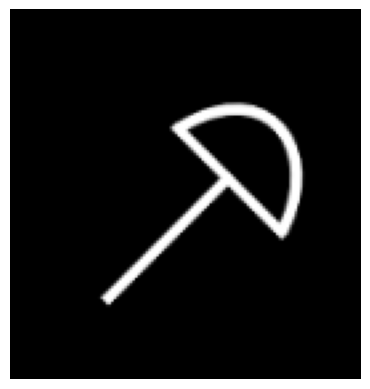

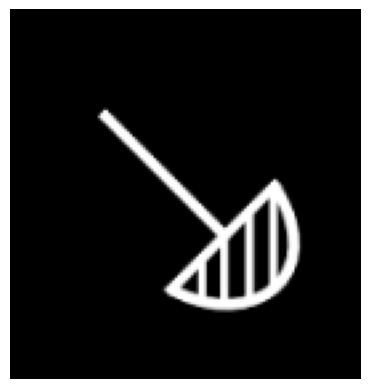

error: OpenCV(4.9.0) /io/opencv/modules/calib3d/src/fundam.cpp:385: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'


In [9]:
def merge_panorama(image1, image2):
    
    # Initialize the feature detector
    sift = cv2.SIFT_create()

    # Detect features and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    # Match features
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

    # Filter matches using the Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Extract location of good matches
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

    # Find homography
    H, _ = cv2.findHomography(points2, points1, cv2.RANSAC)

    # Warp images
    height, width, channels = image1.shape
    result = cv2.warpPerspective(image2, H, (width * 2, height))

    # Copy image1 onto the panorama
    result[0:image1.shape[0], 0:image1.shape[1]] = image1
    return result

# try it out
circles_rotating = iq_test_to_squares(get_image('iq_images/iq16.png'))
img1 = circles_rotating[0]
img2 = circles_rotating[1]
show_image(img1)
show_image(img2)
show_image(merge_panorama(img1, img2))